# Оценка показателя Херста методом Backward Detrended Moving Average (BDMA/DMA)

В этом ноутбуке демонстрируется реализация метода **Backward DMA (BDMA)** для оценки показателя Херста $H$ по временным рядам типа fBm и fGn.

## Теоретическая основа

Метод опирается на следующие шаги для исходного временного ряда $x(t)$, $t = 1, \dots, N$:

### 1. Интегрирование (опционально)
- Если `n_integral = 1`, строится интегрированный ряд
  $$
  y(t) = \sum_{i=1}^{t} x(i),
  $$
  что соответствует модели fractional Brownian motion (fBm), а исходный ряд интерпретируется как fractional Gaussian noise (fGn) — приращения процесса fBm.
- Если `n_integral = 0`, используется исходный ряд $x(t)$ как есть.

Таким образом, один и тот же алгоритм применим и к fBm, и к fGn.

### 2. Построение локального тренда (backward moving average)
Для заданного масштаба окна $n$ (где $10 \le n \le N/4$) вычисляется обратное скользящее среднее:
$$
\tilde y(t) = \frac{1}{n} \sum_{k=0}^{n-1} y(t-k), \quad t = n, n+1, \dots, N.
$$
Этот вариант называется **backward DMA (BDMA)**: он не использует будущие значения ряда, что делает его применимым к потоковым данным.

### 3. Функция флуктуаций
Определяется как среднеквадратичное отклонение от локального тренда:
$$
F(n) = \sqrt{ \frac{1}{M} \sum_{t=n}^{N} \bigl( y(t) - \tilde y(t) \bigr)^2 },
$$
где $M = N - n + 1$ — количество точек для данного масштаба $n$.

### 4. Оценка показателя Херста $H$
При выполнении степенного закона
$$
F(n) \sim n^H,
$$
показатель Херста оценивается как наклон линейной регрессии зависимости $\log F(n)$ от $\log n$ в выбранном диапазоне масштабов.

In [65]:
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import time
import pandas as pd

%matplotlib inline

np.random.seed(42)


In [66]:
def estimate_hurst(F, s):
    return stats.linregress(np.log(s), np.log(F)).slope


def generate_fractional_noise(h: float, length: int):
    """Generate fGn using Kasdin filter method (same as in test_fa)."""
    z = np.random.normal(size=length * 2)
    beta = 2 * h - 1
    L = length * 2
    A = np.zeros(L)
    A[0] = 1
    for k in range(1, L):
        A[k] = (k - 1 - beta / 2) * A[k - 1] / k

    if h == 0.5:  # white noise case
        Z = z
    else:
        Z = signal.lfilter(1, A, z)

    return Z[:length]


def generate_fbm(h: float, length: int):
    """Integrate fGn to produce fBm."""
    return np.cumsum(generate_fractional_noise(h, length))


## Пример 1. Оценка H для fGn с \\(H = 0.7\\)

Сгенерируем один временной ряд длины \\(N = 2^{14}\\), оценим функцию \\(F(n)\\)
и показатель Херста \\(H\\). Построим:

* временной ряд;
* зависимость \\(\\log F(n)\\) от \\(\\log n\\) с линейной аппроксимацией.

In [67]:
from StatTools.analysis.bma import bma
from StatTools.analysis.dpcca import dpcca

H_true = 0.70, H_est = 0.728


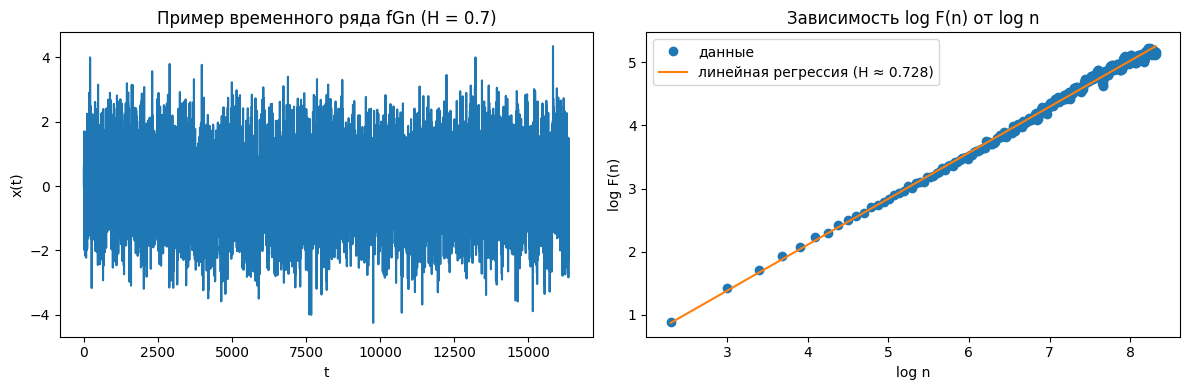

<Figure size 640x480 with 0 Axes>

In [68]:
H_true = 0.7
N = 2**14

sig_fgn = generate_fractional_noise(H_true, N)

# Масштабы от 10 до N/4
scales = np.arange(10, N // 4, 10)

F_vals, used_scales = bma(sig_fgn, s=scales, n_integral=1, step=0.5)
H_est = estimate_hurst(F_vals, used_scales)

print(f"H_true = {H_true:.2f}, H_est = {H_est:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Временной ряд
axes[0].plot(sig_fgn)
axes[0].set_title("Пример временного ряда fGn (H = 0.7)")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x(t)")

# log-log F(n)
axes[1].plot(np.log(used_scales), np.log(F_vals), marker="o", linestyle="None", label="данные")

# Прямая регрессии
lr = stats.linregress(np.log(used_scales), np.log(F_vals))
fit_line = lr.intercept + lr.slope * np.log(used_scales)
axes[1].plot(np.log(used_scales), fit_line, label=f"линейная регрессия (H ≈ {lr.slope:.3f})")

axes[1].set_xlabel("log n")
axes[1].set_ylabel("log F(n)")
axes[1].set_title("Зависимость log F(n) от log n")
axes[1].legend()

plt.tight_layout()
plt.show()
plt.savefig("fig1", format="svg") # only for local storage


## Пример 2. Сравнение fBm и fGn при \(H = 0.5\)

Для \(H = 0.5\):

* fBm соответствует обычному броуновскому движению,
* fGn — его приращения (белый шум).

Проверим, что:

* при `n_integral = 0` (fBm) и `n_integral = 1` (fGn) оценки Херста близки к 0.5.


In [75]:
H_values = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 1.9, 2.0]
N = 2**14

# Store results
H_fbm_estimates = []
H_fgn_estimates = []

for H_true in H_values:
    sig_fgn = generate_fractional_noise(H_true, N)
    sig_fbm = np.cumsum(sig_fgn)

    scales = np.arange(10, N // 4, 10)

    # fBm: n_integral = 0
    F_fbm, s_fbm = bma(sig_fbm, s=scales, n_integral=0, step=0.5)
    H_fbm = estimate_hurst(F_fbm, s_fbm)
    H_fbm_estimates.append(H_fbm)

    # fGn: n_integral = 1
    F_fgn, s_fgn = bma(sig_fgn, s=scales, n_integral=1, step=0.5)
    H_fgn = estimate_hurst(F_fgn, s_fgn)
    H_fgn_estimates.append(H_fgn)

    print(f"H_true = {H_true}")
    print(f"H_est (fBm, n_integral=0) = {H_fbm:.3f}")
    print(f"H_est (fGn, n_integral=1) = {H_fgn:.3f}")
    print("-" * 40)

H_true = 0.1
H_est (fBm, n_integral=0) = 0.166
H_est (fGn, n_integral=1) = 0.166
----------------------------------------
H_true = 0.2
H_est (fBm, n_integral=0) = 0.187
H_est (fGn, n_integral=1) = 0.187
----------------------------------------
H_true = 0.4
H_est (fBm, n_integral=0) = 0.361
H_est (fGn, n_integral=1) = 0.361
----------------------------------------
H_true = 0.5
H_est (fBm, n_integral=0) = 0.424
H_est (fGn, n_integral=1) = 0.424
----------------------------------------
H_true = 0.6
H_est (fBm, n_integral=0) = 0.742
H_est (fGn, n_integral=1) = 0.742
----------------------------------------
H_true = 0.8
H_est (fBm, n_integral=0) = 0.598
H_est (fGn, n_integral=1) = 0.598
----------------------------------------
H_true = 1
H_est (fBm, n_integral=0) = 0.937
H_est (fGn, n_integral=1) = 0.937
----------------------------------------
H_true = 1.2
H_est (fBm, n_integral=0) = 0.889
H_est (fGn, n_integral=1) = 0.889
----------------------------------------
H_true = 1.4
H_est (fBm, n

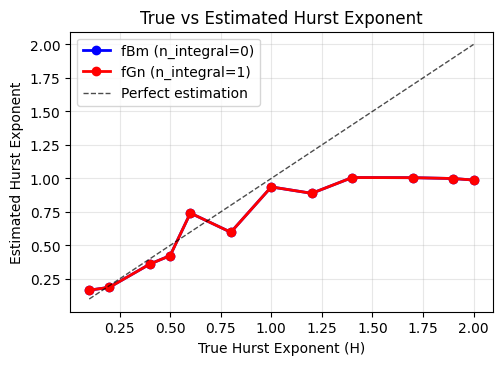

In [76]:
# Create the visualization
plt.figure(figsize=(12, 8))

# Plot 1: True vs Estimated H values
plt.subplot(2, 2, 1)
plt.plot(H_values, H_fbm_estimates, 'bo-', label='fBm (n_integral=0)', linewidth=2, markersize=6)
plt.plot(H_values, H_fgn_estimates, 'ro-', label='fGn (n_integral=1)', linewidth=2, markersize=6)
plt.plot(H_values, H_values, 'k--', label='Perfect estimation', linewidth=1, alpha=0.7)
plt.xlabel('True Hurst Exponent (H)')
plt.ylabel('Estimated Hurst Exponent')
plt.title('True vs Estimated Hurst Exponent')
plt.legend()
plt.grid(True, alpha=0.3)

## План вычислительного эксперимента

### Тестовые данные

Для валидации разработанной реализации использовались синтетические фрактальные временные ряды с заранее известным показателем Херста $H \in \{0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 1.9, 2.0\}$.

**Метод генерации:** метод Касдина (Kasdin)
**Реализация:** из репозитория проекта
**Параметр воспроизводимости:** фиксированное значение `seed`

Данный метод позволяет формировать:
- Фракционное броуновское движение (fBm)
- Фракционный гауссовский шум (fGn)

с заданным показателем Херста и основан на спектральной фильтрации белого шума.

**Длины временных рядов:** $\\(N \in \\{2^{6}, 2^{8}, 2^{10}, 2^{12}, 2^{13}\\}\\)$

### Параметры алгоритма

**Метод:** DMA типа backward (BMA)

**Диапазон масштабов:**
- $n \in [10, N/4]$
- Шаг: 1

**Параметры интегрирования:**
- Для fBm: `n_integral = 0`
- Для fGn: `n_integral = 1`

*Обоснование:* fGn представляет собой приращения fBm, поэтому для корректного анализа фрактальных свойств fGn необходимо интегрирование для восстановления структуры, аналогичной fBm.

### Метрики оценки

1. **Абсолютная ошибка:**
   $$\varepsilon = |H_{est} - H_{true}|$$

2. **Среднеквадратическая ошибка (RMSE):**
   Усреднённая по всем значениям $H$ при фиксированной длине ряда $N$

3. **Время выполнения:**
   - В секундах
   - Учитывается стандартное отклонение по 10 независимым запускам для каждой комбинации $(H, N)$

## Валидация

**Процедура валидации:** соответствует методике репозитория проекта

**Тестовый пример:** модуль `tests/test_fa.py`
- Проверка корректности оценки на временном ряде с $H = 0.5$
- Для fBm с $H = 0.5$ (броуновское движение) ожидаемая оценка ≈ 0.5
- Для fGn с $H = 0.5$ после интегрирования также ожидается ≈ 0.5

**Сравнение:** проводится с реализацией из библиотеки StatTools/analysis dpcca

**Основные критерии:**
- Соответствие теоретическим ожиданиям
- Воспроизводимость результатов

**Визуализация:** зависимость $\log F(n)$ от $\log n$ (вспомогательный инструмент)


**Таблица 1 – Параметры вычислительного эксперимента**

| Параметр                  | Значения/Описание                                                    |
|---------------------------|----------------------------------------------------------------------|
| **Показатель Херста**     | $H \in \{0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 1.9, 2.0\}$ |
| **Длина рядов**           | $\\(N \in \\{2^{6}, 2^{8}, 2^{10}, 2^{12}, 2^{13}\\}\\)$             |
| **Тип процессов**         | fBm, fGn                                                             |
| **Метод генерации**       | Kasdin (спектральная фильтрация)                                     |
| **Алгоритм оценки**       | Backward DMA (BMA)                                                   |
| **Диапазон масштабов**    | $[10, N/4]$ с шагом 1                                                |
| **n_integral**            | 0 (fBm), 1 (fGn)                                                     |
| **Метрики**               | Абсолютная ошибка, RMSE, время выполнения                            |
| **Количество повторений** | Абсолютная ошибка, RMSE, время выполнения                            |

In [72]:
H_values = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 1.9, 2.0]
N_values = [2**6, 2**8, 2**10, 2**12, 2**13]
n_runs = 5

results = []

for series_type in ["fGn", "fBm"]:
    for H_true in H_values:
        for N in N_values:
            print(f"Processing: {series_type}, H={H_true}, N={N}")
            H_estimates = []
            H_dpcca_estimates = []
            times = []

            for _ in range(n_runs):
                if series_type == "fGn":
                    sig = generate_fractional_noise(H_true, N)
                    n_integral = 1
                else:
                    sig = generate_fbm(H_true, N)
                    n_integral = 0

                # Масштабы: от 10 до N/4, шаг примерно N/100, но не меньше 5
                scales = np.arange(10, N // 4, max(5, N // 100))

                t0 = time.perf_counter()
                F_vals, s_vals = bma(sig, s=scales, n_integral=n_integral, step=0.5)
                t1 = time.perf_counter()

                H_est = estimate_hurst(F_vals, s_vals)
                H_estimates.append(H_est)
                times.append(t1 - t0)

				# DPCCA
                P, R, F, S = dpcca(sig, 2, 0.5, scales, len(scales), n_integral=n_integral)
                F = np.sqrt(F)
                H_dpcca_estimates.append(estimate_hurst(F, S))


            H_estimates = np.array(H_estimates)
            H_dpcca_estimates = np.array(H_dpcca_estimates)
            times = np.array(times)

            eps_mean = np.mean(np.abs(H_estimates - H_true))
            dpcca_eps_mean = np.mean(np.abs(H_dpcca_estimates - H_true))
            rmse = np.sqrt(np.mean((H_estimates - H_true) ** 2))
            dpcca_rmse = np.sqrt(np.mean((H_dpcca_estimates - H_true) ** 2))
            t_mean = np.mean(times)
            t_std = np.std(times)

            results.append(
                {
                    "type": series_type,
                    "H_true": H_true,
                    "N": N,
                    "eps_mean": eps_mean,
                    "dpcca_eps_mean": dpcca_eps_mean,
                    "rmse": rmse,
                    "dpcca_rmse": dpcca_rmse,
                    "time_mean_sec": t_mean,
                    "time_std_sec": t_std,
                }
            )

df_results = pd.DataFrame(results)
df_results


Processing: fGn, H=0.1, N=64
Processing: fGn, H=0.1, N=256
Processing: fGn, H=0.1, N=1024
Processing: fGn, H=0.1, N=4096
Processing: fGn, H=0.1, N=8192
Processing: fGn, H=0.2, N=64
Processing: fGn, H=0.2, N=256
Processing: fGn, H=0.2, N=1024
Processing: fGn, H=0.2, N=4096
Processing: fGn, H=0.2, N=8192
Processing: fGn, H=0.4, N=64
Processing: fGn, H=0.4, N=256
Processing: fGn, H=0.4, N=1024
Processing: fGn, H=0.4, N=4096
Processing: fGn, H=0.4, N=8192
Processing: fGn, H=0.5, N=64
Processing: fGn, H=0.5, N=256
Processing: fGn, H=0.5, N=1024
Processing: fGn, H=0.5, N=4096
Processing: fGn, H=0.5, N=8192
Processing: fGn, H=0.6, N=64
Processing: fGn, H=0.6, N=256
Processing: fGn, H=0.6, N=1024
Processing: fGn, H=0.6, N=4096
Processing: fGn, H=0.6, N=8192
Processing: fGn, H=0.8, N=64
Processing: fGn, H=0.8, N=256
Processing: fGn, H=0.8, N=1024
Processing: fGn, H=0.8, N=4096
Processing: fGn, H=0.8, N=8192
Processing: fGn, H=1, N=64
Processing: fGn, H=1, N=256
Processing: fGn, H=1, N=1024
Proc

,type,H_true,N,eps_mean,dpcca_eps_mean,rmse,dpcca_rmse,time_mean_sec,time_std_sec
0,fGn,0.1,64,0.647613,0.194303,0.690260,0.273180,0.000185,0.000118
1,fGn,0.1,256,0.074399,0.173546,0.099979,0.176673,0.000343,0.000017
2,fGn,0.1,1024,0.077941,0.120246,0.091777,0.120909,0.000874,0.000115
3,fGn,0.1,4096,0.054592,0.079626,0.057868,0.080646,0.002037,0.000826
4,fGn,0.1,8192,0.021673,0.078991,0.034386,0.079427,0.002396,0.000097
...,...,...,...,...,...,...,...,...,...
115,fBm,2.0,64,0.780875,0.328825,0.791327,0.397487,0.000097,0.000013
116,fBm,2.0,256,0.983892,0.121072,0.984264,0.157392,0.000327,0.000009
117,fBm,2.0,1024,0.988534,0.082949,0.989304,0.083940,0.000898,0.000083
118,fBm,2.0,4096,1.002151,0.047537,1.002196,0.055233,0.001565,0.000098


### Табличное резюме

Сгруппируем результаты по типу ряда и длине \(N\), усредняя по всем значениям \(H\)
(как в таблице эксперимента для RMSE и времени).


In [86]:
summary = (
    df_results
    .groupby(["type", "N", "H_true"])
    .agg(
        eps_mean=("eps_mean", "mean"),
        rmse_mean=("rmse", "mean"),
        dpcca_rmse_mean=("dpcca_rmse", "mean"),
        rmse_std=("rmse", "std"),
        dpcca_rmse_std=("dpcca_rmse", "std"),
        time_mean_sec=("time_mean_sec", "mean"),
        time_std_sec=("time_std_sec", "mean"),
    )
    .reset_index()
)
summary


,type,N,H_true,eps_mean,rmse_mean,dpcca_rmse_mean,rmse_std,dpcca_rmse_std,time_mean_sec,time_std_sec
0,fBm,64,0.1,0.840004,0.906888,0.237179,NaN,NaN,0.000118,0.000018
1,fBm,64,0.2,0.206185,0.242721,0.241572,NaN,NaN,0.000101,0.000014
2,fBm,64,0.4,0.798610,0.940287,0.167239,NaN,NaN,0.000110,0.000008
3,fBm,64,0.5,0.459583,0.560823,0.138193,NaN,NaN,0.000102,0.000011
4,fBm,64,0.6,0.370631,0.444670,0.362926,NaN,NaN,0.000101,0.000005
...,...,...,...,...,...,...,...,...,...,...
115,fGn,8192,1.2,0.235089,0.240076,0.044887,NaN,NaN,0.002312,0.000072
116,fGn,8192,1.4,0.413833,0.416018,0.020851,NaN,NaN,0.002314,0.000052
117,fGn,8192,1.7,0.689524,0.689567,0.064281,NaN,NaN,0.002354,0.000038
118,fGn,8192,1.9,0.894613,0.894815,0.068257,NaN,NaN,0.002371,0.000046


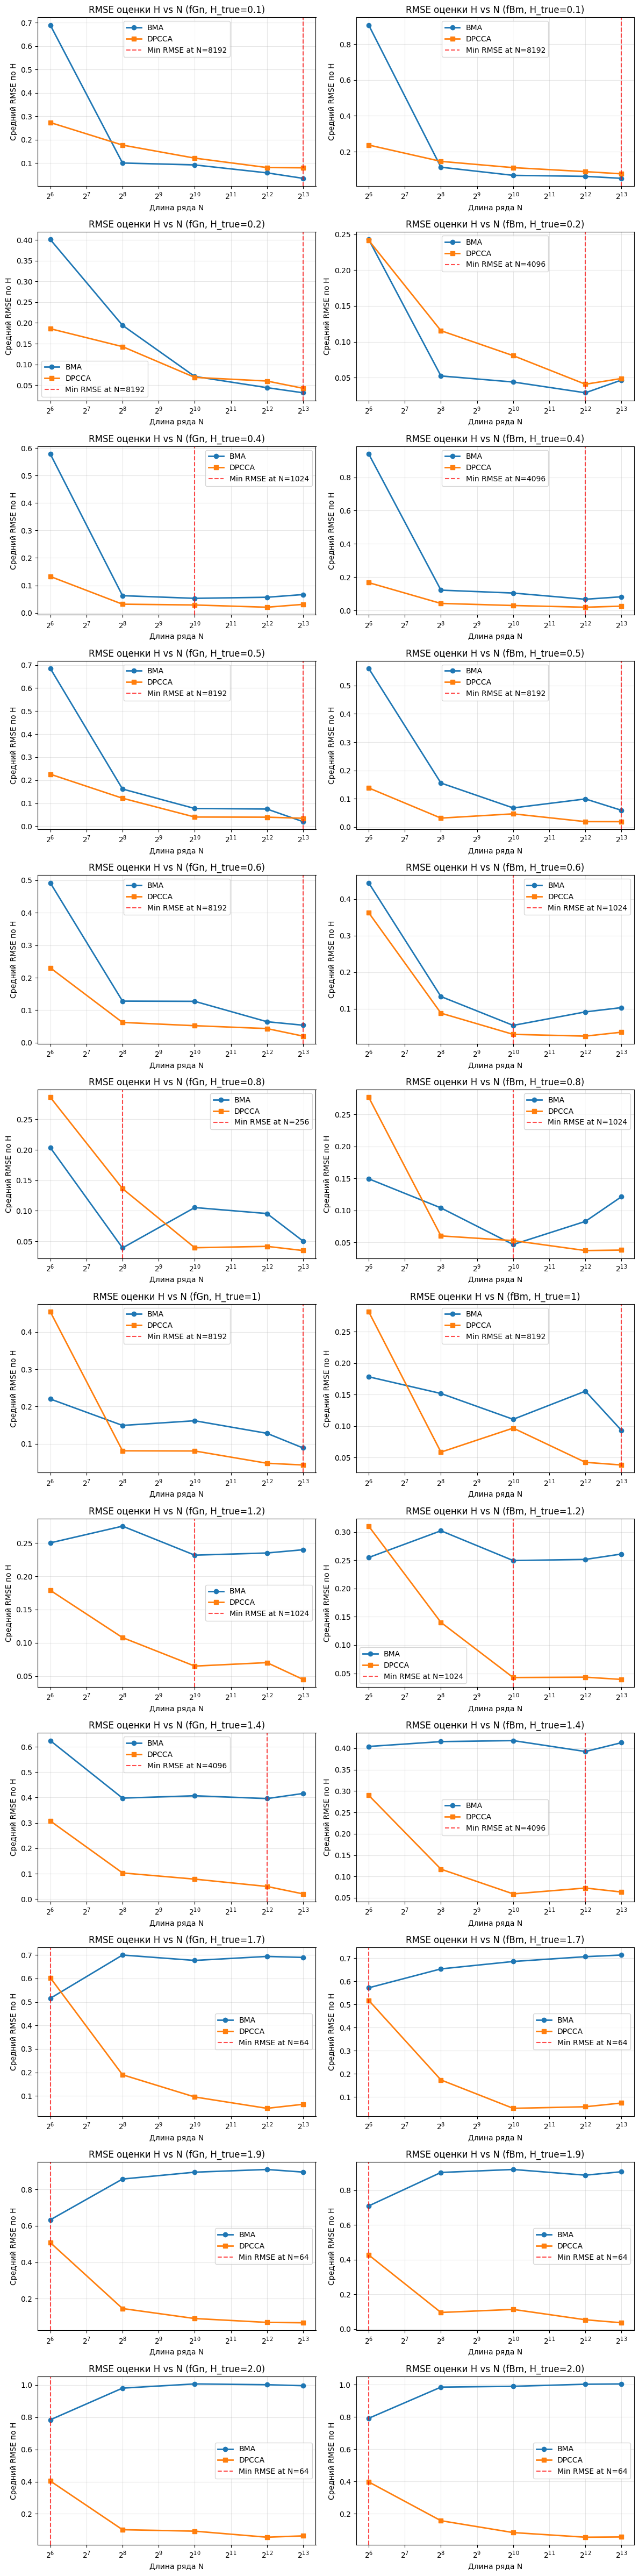

In [81]:
fig, axes = plt.subplots(len(H_values), 2, figsize=(12, 4 * len(H_values)))
if len(H_values) == 1:
    axes = axes.reshape(1, -1)  # Ensure 2D array even with single H_value

for i, h in enumerate(H_values):
    for j, series_type in enumerate(["fGn", "fBm"]):
        ax = axes[i, j]

        # Fixed: use & for element-wise comparison and parentheses for proper grouping
        sub = summary[(summary["type"] == series_type) & (summary["H_true"] == h)]

        # Sort by N to ensure proper plotting
        sub = sub.sort_values("N")

        # Обычные графики с точками и линиями
        ax.plot(
            sub["N"],
            sub["rmse_mean"],
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=6,
            label="BMA"
        )
        ax.plot(
            sub["N"],
            sub["dpcca_rmse_mean"],
            marker="s",
            linestyle="-",
            linewidth=2,
            markersize=6,
            label="DPCCA"
        )

        # Минимально адекватная длина ряда: точка с минимальным RMSE
        if not sub.empty:
            idx_min = sub["rmse_mean"].idxmin()
            N_min = sub.loc[idx_min, "N"]
            ax.axvline(N_min, linestyle="--", alpha=0.7, color='red',
                       label=f'Min RMSE at N={N_min}')

        ax.set_xscale("log", base=2)
        ax.set_xlabel("Длина ряда N")
        ax.set_ylabel("Средний RMSE по H")
        ax.set_title(f"RMSE оценки H vs N ({series_type}, H_true={h})")
        ax.legend()

        # Add grid for better readability
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("all_rmse_comparisons.svg", format="svg")
plt.show()

### Зависимость точности от истинного \(H\)

Теперь посмотрим, как меняется ошибка в зависимости от \(H_\text{true}\)
(усреднено по длинам \(N\)).


In [79]:
summary_H = (
    df_results
    .groupby(["type", "H_true"])
    .agg(
        eps_mean=("eps_mean", "mean"),
        rmse_mean=("rmse", "mean"),
        rmse_std=("rmse", "std"),
        dpcca_rmse_mean=("dpcca_rmse", "mean"),
        dpcca_rmse_std=("dpcca_rmse", "std"),
    )
    .reset_index()
)
summary_H


,type,H_true,eps_mean,rmse_mean,rmse_std,dpcca_rmse_mean,dpcca_rmse_std
0,fBm,0.1,0.218872,0.240380,0.373342,0.131885,0.064526
1,fBm,0.2,0.069794,0.082982,0.089717,0.105546,0.081554
2,fBm,0.4,0.221358,0.263311,0.379018,0.056933,0.062223
3,fBm,0.5,0.160691,0.188412,0.211597,0.050860,0.050126
4,fBm,0.6,0.138462,0.165411,0.158651,0.108332,0.144545
5,fBm,0.8,0.088050,0.100833,0.038924,0.092976,0.103338
6,fBm,1.0,0.121129,0.137817,0.034935,0.103497,0.102212
7,fBm,1.2,0.253500,0.263802,0.021874,0.115075,0.117184
8,fBm,1.4,0.399137,0.408782,0.010475,0.120579,0.097472
9,fBm,1.7,0.664546,0.666405,0.057665,0.174795,0.198091


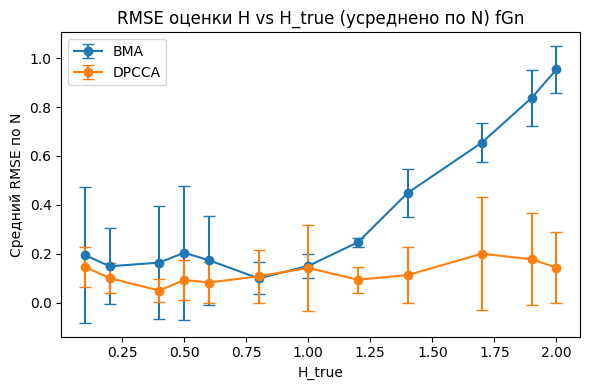

<Figure size 640x480 with 0 Axes>

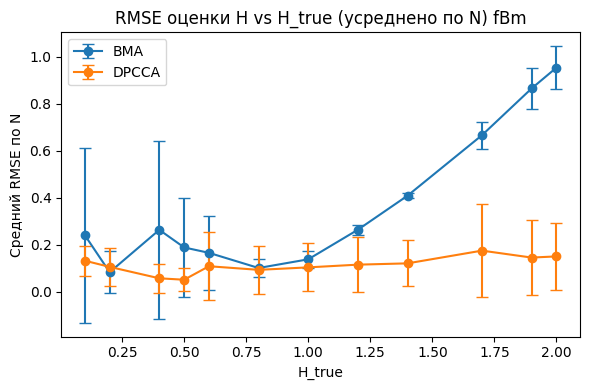

<Figure size 640x480 with 0 Axes>

In [80]:
for series_type in ["fGn", "fBm"]:
    fig, ax = plt.subplots(figsize=(6, 4))
    sub = summary_H[summary_H["type"] == series_type]
    ax.errorbar(
        sub["H_true"],
        sub["rmse_mean"],
        yerr=sub["rmse_std"],
        marker="o",
        capsize=4,
        label="BMA"
    )
    ax.errorbar(
        sub["H_true"],
        sub["dpcca_rmse_mean"],
        yerr=sub["dpcca_rmse_std"],
        marker="o",
        capsize=4,
        label="DPCCA"
    )

    ax.set_xlabel("H_true")
    ax.set_ylabel("Средний RMSE по N")
    ax.set_title("RMSE оценки H vs H_true (усреднено по N) " + series_type)
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig("fig4"+series_type, format="svg") # only for local storage

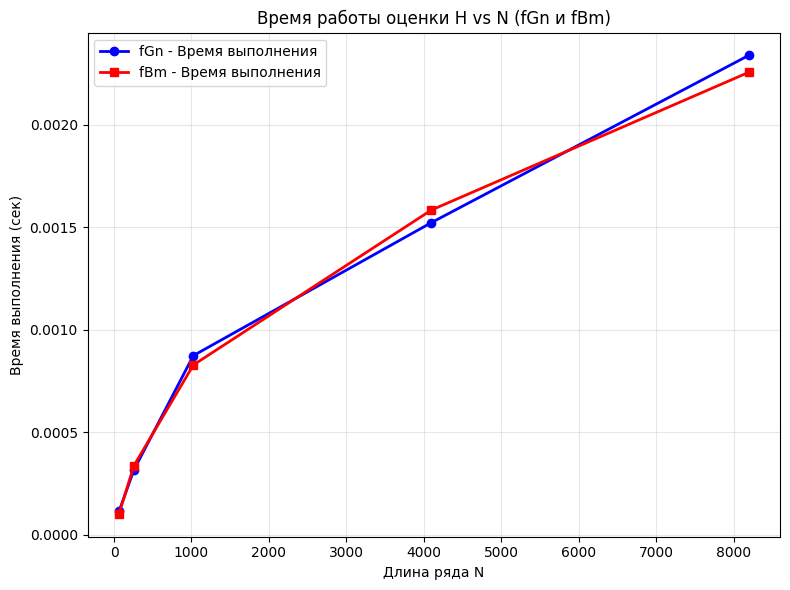

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

# Цвета и маркеры для разных типов рядов
colors = ['blue', 'red']
markers = ['o', 's']

for j, series_type in enumerate(["fGn", "fBm"]):
    # Выбираем данные для текущего типа ряда и H_true = 0.5
    sub = summary[(summary["type"] == series_type) & (summary["H_true"] == 0.5)]

    # Сортируем по N для правильного построения графика
    sub = sub.sort_values("N")

    # Простой график с точками и линиями
    ax.plot(
        sub["N"],
        sub["time_mean_sec"],
        marker=markers[j],
        linestyle="-",
        linewidth=2,
        markersize=6,
        color=colors[j],
        label=f"{series_type} - Время выполнения"
    )

ax.set_xlabel("Длина ряда N")
ax.set_ylabel("Время выполнения (сек)")
ax.set_title("Время работы оценки H vs N (fGn и fBm)")
ax.legend()

# Добавляем сетку для лучшей читаемости
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("execution_time_vs_N.svg", format="svg")
plt.show()

## Выводы по результатам численных экспериментов

На основе таблиц и графиков можно сделать следующие наблюдения.

1. **Рост длины ряда \\(N\\) улучшает точность оценки.**
   Это соответствует теоретическим ожиданиям:
   для корректной оценки масштабных характеристик требуется достаточно длинный ряд.

2. **Точность зависит от значения \\(H_{\\text{true}}\\).**
   Обычно наибольшая точность достигается около средних значений

3. **fGn vs fBm.**
   При корректном выборе параметра `n_integral`
   (`0` для fBm и `1` для fGn) качество оценки сопоставимо.
   Различия между типами мало заметны.

4. **Время выполнения растёт примерно линейно по \\(N\\).**
   Время работы BMA увеличивается с длиной ряда. При этом метод
   использует только прошлые значения и может быть реализован в потоковом
  /онлайновом режиме, что соответствует поставленной задаче.

5. Для H>1 алгоритм перестает корректно работать

В целом реализованный алгоритм BMA даёт разумные оценки показателя Херста
для синтетических рядов fGn и fBm в широком диапазоне параметров и
демонстрирует ожидаемую зависимость точности от длины ряда и истинного
значения \\(H\\).

## Сравнение метода BMA/DMA с реализацией DFA из библиотеки `nolds`

Для справочной проверки сравним оценки показателя Херста, полученные методом BMA/DMA,
с результатами стандартной реализации detrended fluctuation analysis (DFA)
из библиотеки **nolds**.

Важно:  
*Этот тест не является строгим эталоном*, так как разные методы дают несколько
отличающиеся оценки, однако согласованность в среднем подтверждает корректность
масштабного поведения алгоритма BMA.


In [89]:
try:
    import nolds
    nolds_available = True
except ImportError:
    print("⚠ Библиотека nolds не установлена — блок сравнения будет пропущен.")
    nolds_available = False


In [90]:
if nolds_available:
    H_values_compare = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]
    N = 2**14
    n_integral = 1  # работаем с fGn

    compare_rows = []

    for H_true in H_values_compare:
        rng = np.random.default_rng(2024 + int(100 * H_true))

        sig = generate_fractional_noise(H_true, N)

        # --- BMA ---
        scales = np.arange(10, N // 4, 10)
        F_vals, s_vals = bma(sig, scales, n_integral=n_integral, step=0.5)
        H_bma = estimate_hurst(F_vals, s_vals)

        # --- nolds DFA ---
        H_dfa = nolds.dfa(sig)

        compare_rows.append({
            "H_true": H_true,
            "H_bma": H_bma,
            "H_dfa": H_dfa,
            "err_bma": abs(H_bma - H_true),
            "err_dfa": abs(H_dfa - H_true),
        })

    df_compare = pd.DataFrame(compare_rows)

    # ЯВНО показываем таблицу
    from IPython.display import display
    display(df_compare.style.format("{:.4f}"))

else:
    df_compare = None
    print("Библиотека nolds недоступна, сравнение BMA vs DFA пропущено.")

/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.13/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.13/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.13/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.13/site-packages/nolds/measures.py:31: RuntimeWarning: fitting mode 'RANSAC' requires the package sklearn, using 'poly' instead
  warnings.warn(
/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/my_new_venv/lib/python3.

,H_true,H_bma,H_dfa,err_bma,err_dfa
0,0.1000,0.1400,0.1975,0.0400,0.0975
1,0.3000,0.3381,0.3511,0.0381,0.0511
2,0.5000,0.5198,0.4959,0.0198,0.0041
3,0.7000,0.6706,0.6851,0.0294,0.0149
4,1.0000,0.9138,1.0063,0.0862,0.0063
5,1.5000,1.0036,1.5066,0.4964,0.0066
6,2.0000,0.9887,1.9835,1.0113,0.0165


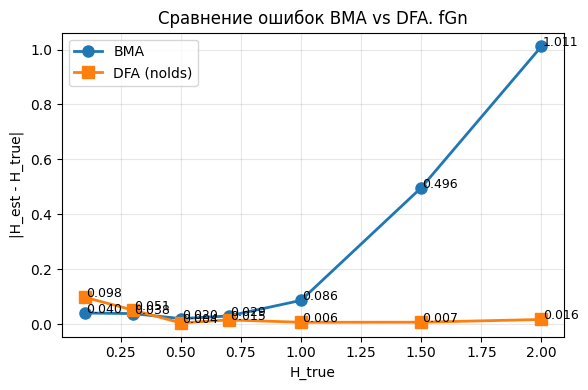

<Figure size 640x480 with 0 Axes>

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

H = df_compare["H_true"]

# линии + точки
ax.plot(H, df_compare["err_bma"], "-o", label="BMA", linewidth=2, markersize=8)
ax.plot(H, df_compare["err_dfa"], "-s", label="DFA (nolds)", linewidth=2, markersize=8)

# подписи точек
for i, row in df_compare.iterrows():
    ax.text(row["H_true"] + 0.005, row["err_bma"], f"{row['err_bma']:.3f}", fontsize=9)
    ax.text(row["H_true"] + 0.005, row["err_dfa"], f"{row['err_dfa']:.3f}", fontsize=9)

ax.set_xlabel("H_true")
ax.set_ylabel("|H_est - H_true|")
ax.set_title("Сравнение ошибок BMA vs DFA. fGn")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("fig5", format="svg") # only for local storage